In [1]:
metadata_path = "../data/db2/MFD_metadatas.csv"
max_days = 365 * 3

In [2]:
from mandrillage.dataset import read_dataset, MandrillImageDataset
dataset = read_dataset(
    metadata_path,
    filter_dob_error=True,
    filter_certainty=False,
    max_age=max_days,
    max_dob_error=10,
    sex=None
)

/home/rkarpins/miniconda3/envs/mar/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Filtered #-1897 (44729/46626)


In [3]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

dataset_reader = MandrillImageDataset("../data/db2/Images",
        dataset,
        img_size=(224, 224),
        in_mem=False,
        max_days=1,
        individuals_ids=[],
        max_nbins=12,
        training=False)

def to_float(str_value):
    if "," in str_value:
        str_value = str_value.replace(",", ".")
    return float(str_value)

def f2i(f_value, scale=1):
    return int(f_value * scale)

def get_row_coords(row, x, y, scale_x, scale_y):
    return f2i(to_float(row[x]), scale_x), f2i(to_float(row[y]), scale_y)

def _merge_images(img_top, img_bottom, mask=0):
    """
    Function to combine two images with mask by replacing all pixels of img_bottom which
    equals to mask by pixels from img_top.

    :param img_top: greyscale image which will replace masked pixels
    :param img_bottom: greyscale image which pixels will be replace
    :param mask: pixel value to be used as mask (int)
    :return: combined greyscale image
    """
    import skimage
    img_top = skimage.img_as_ubyte(img_top)
    img_bottom = skimage.img_as_ubyte(img_bottom)
    merge_layer = img_top == mask
    img_top[merge_layer] = img_bottom[merge_layer]
    return img_top

def swap_faces(src_face, dst_face, src_face_lm, dst_face_lm):
    output_shape = dst_face.shape[:2]
    src_face_coord = src_face_lm[0]
    dst_face_coord = dst_face_lm[0]
    import skimage
    warp_trans = skimage.transform.PiecewiseAffineTransform()
    warp_trans.estimate(dst_face_coord, src_face_coord)
    warped_face = skimage.transform.warp(src_face, warp_trans, output_shape=output_shape)
    warped_face = _merge_images(warped_face, dst_face)
    return warped_face

import face_alignment
from skimage import io
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, face_detector="sfd")

nrows = 4
ncols = 5
n_images = nrows * ncols
last_landmark_im = None
# fig, axs = plt.subplots(nrows, ncols, figsize=(12,8))
# for i in range(n_images):
#     row = dataset.iloc[i*40]
#     fig_row = i// ncols
#     fig_col = i % ncols
    
#     ax_normal = axs[fig_row, fig_col]
#     # ax_swap = axs[fig_row+1, fig_col]
    
#     photo = dataset_reader.load_photo(row, normalize=False)
#     photo = cv2.resize(photo, (256, 256), interpolation=cv2.INTER_AREA)
#     width, height = photo.shape[0], photo.shape[1]
    
#     preds = fa.get_landmarks_from_image(photo, detected_faces=[np.array([0,0,width,height])])
    
    # if last_landmark_im is not None:
    #     src_face, src_face_lm = last_landmark_im
    #     warped_face = swap_faces(src_face, photo.copy(), src_face_lm, preds)

    #     # Display on warped
    #     # warped_preds = fa.get_landmarks_from_image(warped_face, detected_faces=[np.array([0,0,width,height])])
    #     # for face_landmarks in warped_preds:
    #     #     for (x, y) in face_landmarks:
    #     #         cv2.circle(warped_face, (int(x), int(y)), 5, (0, 0, 255), -1)

    #     ax_swap.imshow(warped_face)
    # else:
    #     ax_swap.imshow(photo)

    # display on normal
    # for face_landmarks in preds:
    #     for (x, y) in face_landmarks:
    #         cv2.circle(photo, (int(x), int(y)), 5, (0, 0, 255), -1)
    
    # last_landmark_im = (photo, preds)

    # ax_normal.imshow(photo)
    
    
    

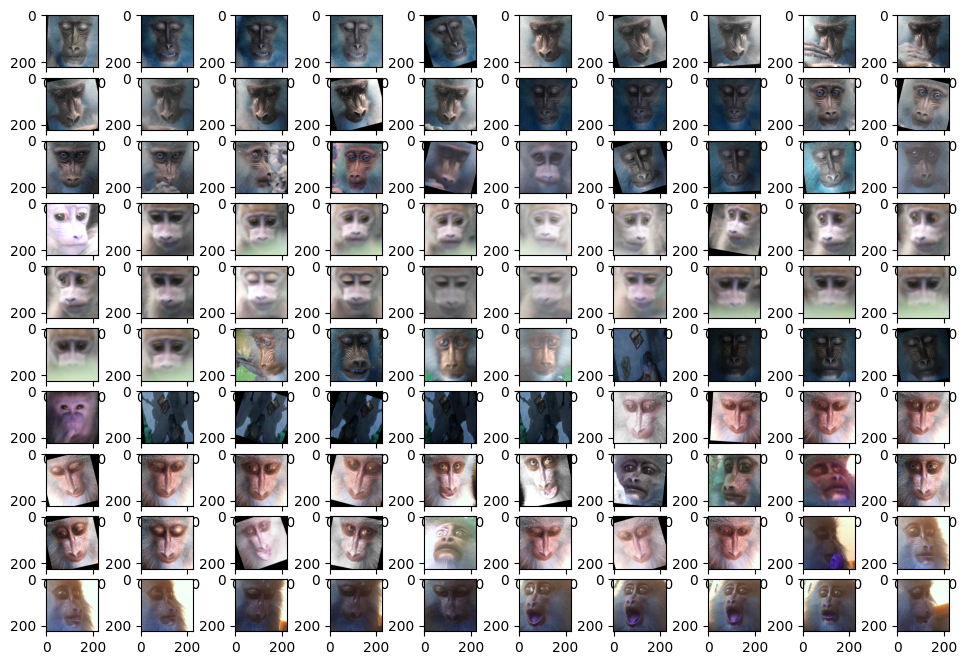

In [4]:
from mandrillage.dataset import AugmentedDataset
import numpy as np

augmented = AugmentedDataset(dataset_reader)

nrows = 10
ncols = 10
n_images = nrows * ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(12,8))
for i in range(n_images):
    x, y = augmented[i]
    fig_row = i // ncols
    fig_col = i % ncols
    
    ax = axs[fig_row, fig_col] 
    ax.imshow(np.moveaxis(x, 0, -1))